### import library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

def MAPE(y_test, y_pred):
   return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
from sklearn.metrics import r2_score

def acc(y_test,pred):
    y = y_test[abs(y_test-pred)/y_test<0.05]
    return len(y)/len(y_test)

import shap #SHAP package

In [2]:
def plotTestingDataPredictions_5(testingLabelData, testingDataPredictions):
    plt.figure(figsize=(10, 8))
    # Plot the data points (x, y)
    plt.scatter(testingLabelData, testingDataPredictions, color = 'blue')

    # Label the axes
    plt.xlabel('True Win_Rate (W / G)')
    plt.ylabel('Predicted Win_Rate (W / G)')

    # Plot a line between (0,0) and (50,50) 
    point1 = [0, 0]
    point2 = [1, 1]
    xValues = [point1[0], point2[0]] 
    yValues = [point1[1], point2[1]]
    plt.plot(xValues, yValues, color = 'black') 

    point1 = [0, 0]
    point2 = [1, 1.05]
    xValues = [point1[0], point2[0]] 
    yValues = [point1[1], point2[1]]
    plt.plot(xValues, yValues, color = 'red') 

    point1 = [0, 0]
    point2 = [1, 0.95]
    xValues = [point1[0], point2[0]] 
    yValues = [point1[1], point2[1]]
    plt.plot(xValues, yValues, color = 'red') 

    # Set the x and y axes limits
    plt.xlim(0.3, 0.7)
    plt.ylim(0.3, 0.7)

    # x and y axes are equal in displayed dimensions
    plt.gca().set_aspect('equal', adjustable='box')

    # Show the plot
    plt.show()

### Team data

In [3]:
df = pd.read_csv('./baseballdatabank-2022.2/core/Teams.csv')

In [4]:
df.isnull().sum()

yearID               0
lgID                50
teamID               0
franchID             0
divID             1517
Rank                 0
G                    0
Ghome              399
W                    0
L                    0
DivWin            1545
WCWin             2181
LgWin               28
WSWin              357
R                    0
AB                   0
H                    0
2B                   0
3B                   0
HR                   0
BB                   1
SO                  16
SB                 126
CS                 832
HBP               1158
SF                1541
RA                   0
ER                   0
ERA                  0
CG                   0
SHO                  0
SV                   0
IPouts               0
HA                   0
HRA                  0
BBA                  0
SOA                  0
E                    0
DP                   0
FP                   0
name                 0
park                34
attendance         279
BPF        

### 1970 ~

In [5]:
df = df[df['yearID'] >= 1970]

In [6]:
df.columns
df = df.drop(['L', 'Rank', 'DivWin', 'WCWin', 'LgWin', 'WSWin'],axis=1)

In [7]:
df['Win_rate'] = df['W'] / df['G']
df = df.dropna()
len(df)

1444

In [8]:
df = df.drop(['W'], axis = 1)
df.isnull().sum()

yearID            0
lgID              0
teamID            0
franchID          0
divID             0
G                 0
Ghome             0
R                 0
AB                0
H                 0
2B                0
3B                0
HR                0
BB                0
SO                0
SB                0
CS                0
HBP               0
SF                0
RA                0
ER                0
ERA               0
CG                0
SHO               0
SV                0
IPouts            0
HA                0
HRA               0
BBA               0
SOA               0
E                 0
DP                0
FP                0
name              0
park              0
attendance        0
BPF               0
PPF               0
teamIDBR          0
teamIDlahman45    0
teamIDretro       0
Win_rate          0
dtype: int64

In [9]:
df = df.drop(['franchID', 'name', 'park', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'],axis=1)

### Cy Young Award

In [10]:
AwardsPlayers = pd.read_csv('./baseballdatabank-2022.2/contrib/AwardsPlayers.csv')
AwardsPlayers

Pitching = pd.read_csv('./baseballdatabank-2022.2/core/Pitching.csv')
Pitching

CyYoung = pd.merge(Pitching, AwardsPlayers, on = ['playerID', 'yearID'])
CyYoung = CyYoung[CyYoung['awardID'] == 'Cy Young Award']
CyYoung = CyYoung[CyYoung['yearID'] >= 1970]

print(len(CyYoung))

CyYoung = CyYoung[['yearID', 'teamID', 'playerID']]

df = pd.merge(df, CyYoung, on = ['yearID', 'teamID'], how = 'left')
df['CyYoung'] = 0
df.loc[df['playerID'].isnull() == False , 'CyYoung'] = 1

105


In [11]:
df.loc[(df['yearID'] == 1984) & (df['teamID'] == 'CLE'), 'CyYoung'] = 0

In [12]:
sum(df['CyYoung'])

104

In [13]:
df = df.drop(['playerID'], axis = 1)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,BBA,SOA,E,DP,FP,attendance,BPF,PPF,Win_rate,CyYoung
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,478,960,141,118,0.977,1078848.0,106,106,0.469136,0
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,469,941,117,148,0.981,1057069.0,101,98,0.666667,0
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,594,1003,156,131,0.974,1595278.0,108,107,0.537037,0
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,559,922,127,169,0.980,1077741.0,96,97,0.530864,0
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,556,762,165,187,0.975,495355.0,101,102,0.345679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,608,1225,84,137,0.986,2102530.0,92,92,0.555556,0
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,436,1478,80,130,0.986,761072.0,92,91,0.617284,0
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,513,1239,83,146,0.986,2110258.0,99,101,0.370370,0
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,473,1468,90,122,0.984,805901.0,102,101,0.561728,1


### Rookie of the Year

In [14]:
Batting = pd.read_csv('./baseballdatabank-2022.2/core/Batting.csv')
Batting

Players = pd.concat([Pitching, Batting])
Players = Players[['playerID', 'yearID', 'teamID']]


Players = Players.groupby(['playerID' , 'yearID']).max()
Players = Players.reset_index()

Rookie = pd.merge(Players, AwardsPlayers, on = ['playerID', 'yearID'])
Rookie = Rookie[Rookie['awardID'] == 'Rookie of the Year']
Rookie = Rookie[Rookie['yearID'] >= 1970]

Rookie = Rookie[['yearID', 'teamID', 'playerID']]

In [15]:
df = pd.merge(df, Rookie, on = ['yearID', 'teamID'], how = 'left')
df['Rookie'] = 0
df.loc[df['playerID'].isnull() == False , 'Rookie'] = 1

In [16]:
df = df.drop(['playerID'], axis = 1)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,SOA,E,DP,FP,attendance,BPF,PPF,Win_rate,CyYoung,Rookie
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,960,141,118,0.977,1078848.0,106,106,0.469136,0,0
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,941,117,148,0.981,1057069.0,101,98,0.666667,0,0
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,1003,156,131,0.974,1595278.0,108,107,0.537037,0,0
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,922,127,169,0.980,1077741.0,96,97,0.530864,0,0
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,762,165,187,0.975,495355.0,101,102,0.345679,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,1225,84,137,0.986,2102530.0,92,92,0.555556,0,0
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,1478,80,130,0.986,761072.0,92,91,0.617284,0,1
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,1239,83,146,0.986,2110258.0,99,101,0.370370,0,0
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,1468,90,122,0.984,805901.0,102,101,0.561728,1,0


### Gold Golve

In [17]:
GGlove = pd.merge(Players, AwardsPlayers, on = ['playerID', 'yearID'])
GGlove = GGlove[GGlove['awardID'] == 'Gold Glove']
GGlove = GGlove[GGlove['yearID'] >= 1970]

GGlove = GGlove[['yearID', 'teamID', 'playerID']]

GGlove = GGlove.groupby(['yearID', 'teamID']).count()
GGlove = GGlove.reset_index()

In [18]:
GGlove

,yearID,teamID,playerID
0,1970,BAL,3
1,1970,CAL,1
2,1970,CHA,2
3,1970,CHN,1
4,1970,CIN,3
...,...,...,...
642,2021,PIT,1
643,2021,SFN,1
644,2021,SLN,5
645,2021,TEX,1


In [19]:
df = pd.merge(df, GGlove, on = ['yearID', 'teamID'], how = 'left')
df['GoldGlove'] = 0
df.loc[df['GoldGlove'].isnull() == False , 'GoldGlove'] = df['playerID']
df.loc[df['GoldGlove'].isnull() == True , 'GoldGlove'] = 0

In [20]:
df = df.drop(['playerID'], axis = 1)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,E,DP,FP,attendance,BPF,PPF,Win_rate,CyYoung,Rookie,GoldGlove
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,141,118,0.977,1078848.0,106,106,0.469136,0,0,0.0
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,117,148,0.981,1057069.0,101,98,0.666667,0,0,3.0
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,156,131,0.974,1595278.0,108,107,0.537037,0,0,0.0
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,127,169,0.980,1077741.0,96,97,0.530864,0,0,1.0
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,165,187,0.975,495355.0,101,102,0.345679,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,84,137,0.986,2102530.0,92,92,0.555556,0,0,5.0
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,80,130,0.986,761072.0,92,91,0.617284,0,1,0.0
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,83,146,0.986,2110258.0,99,101,0.370370,0,0,1.0
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,90,122,0.984,805901.0,102,101,0.561728,1,0,1.0


### All-Star

In [21]:
Allstar = pd.merge(Players, AwardsPlayers, on = ['playerID', 'yearID'])
Allstar = Allstar[Allstar['awardID'] == 'TSN All-Star']
Allstar = Allstar[Allstar['yearID'] >= 1970]

Allstar = Allstar[['yearID', 'teamID', 'playerID']]

Allstar = Allstar.groupby(['yearID', 'teamID']).count()
Allstar = Allstar.reset_index()

In [22]:
df = pd.merge(df, Allstar, on = ['yearID', 'teamID'], how = 'left')
df['Allstar'] = 0
df.loc[df['Allstar'].isnull() == False , 'Allstar'] = df['playerID']
df.loc[df['Allstar'].isnull() == True , 'Allstar'] = 0

In [23]:
df = df.drop(['playerID'], axis = 1)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,DP,FP,attendance,BPF,PPF,Win_rate,CyYoung,Rookie,GoldGlove,Allstar
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,118,0.977,1078848.0,106,106,0.469136,0,0,0.0,1.0
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,148,0.981,1057069.0,101,98,0.666667,0,0,3.0,2.0
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,131,0.974,1595278.0,108,107,0.537037,0,0,0.0,1.0
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,169,0.980,1077741.0,96,97,0.530864,0,0,1.0,0.0
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,187,0.975,495355.0,101,102,0.345679,0,0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,137,0.986,2102530.0,92,92,0.555556,0,0,5.0,0.0
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,130,0.986,761072.0,92,91,0.617284,0,1,0.0,0.0
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,146,0.986,2110258.0,99,101,0.370370,0,0,1.0,0.0
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,122,0.984,805901.0,102,101,0.561728,1,0,1.0,2.0


### League MVP

In [24]:
AwardsPlayers[AwardsPlayers['awardID'] == 'Most Valuable Player']

,playerID,awardID,yearID,lgID,tie,notes
188,cobbty01,Most Valuable Player,1911,AL,NaN,NaN
189,schulfr01,Most Valuable Player,1911,NL,NaN,NaN
226,speaktr01,Most Valuable Player,1912,AL,NaN,NaN
227,doylela01,Most Valuable Player,1912,NL,NaN,NaN
258,johnswa01,Most Valuable Player,1913,AL,NaN,NaN
...,...,...,...,...,...,...
6312,bellico01,Most Valuable Player,2019,NL,NaN,NaN
6386,abreujo02,Most Valuable Player,2020,AL,NaN,NaN
6387,freemfr01,Most Valuable Player,2020,NL,NaN,NaN
6459,ohtansh01,Most Valuable Player,2021,AL,NaN,NaN


In [25]:
MVP = pd.merge(Players, AwardsPlayers, on = ['playerID', 'yearID'])
MVP = MVP[MVP['awardID'] == 'Most Valuable Player']
MVP = MVP[MVP['yearID'] >= 1970]

MVP = MVP[['yearID', 'teamID', 'playerID']]

In [26]:
df = pd.merge(df, MVP, on = ['yearID', 'teamID'], how = 'left')
df['MVP'] = 0
df.loc[df['playerID'].isnull() == False , 'MVP'] = 1

In [27]:
df = df.drop(['playerID'], axis = 1)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,FP,attendance,BPF,PPF,Win_rate,CyYoung,Rookie,GoldGlove,Allstar,MVP
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,0.977,1078848.0,106,106,0.469136,0,0,0.0,1.0,0
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,0.981,1057069.0,101,98,0.666667,0,0,3.0,2.0,1
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,0.974,1595278.0,108,107,0.537037,0,0,0.0,1.0,0
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,0.980,1077741.0,96,97,0.530864,0,0,1.0,0.0,0
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,0.975,495355.0,101,102,0.345679,0,0,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,0.986,2102530.0,92,92,0.555556,0,0,5.0,0.0,0
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,0.986,761072.0,92,91,0.617284,0,1,0.0,0.0,0
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,0.986,2110258.0,99,101,0.370370,0,0,1.0,0.0,0
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,0.984,805901.0,102,101,0.561728,1,0,1.0,2.0,0


### Batter Average

In [28]:
People = pd.read_csv('./baseballdatabank-2022.2/core/People.csv')
People = People[['playerID', 'birthYear', 'birthCountry', 'weight', 'height', 'bats', 'throws', 'debut']]

In [29]:
Batter = pd.merge(Batting, People, on = 'playerID')
Batter = Batter[Batter['yearID'] >= 1970]
Batter.isnull().sum()

playerID        0
yearID          0
stint           0
teamID          0
lgID            0
G               0
AB              0
R               0
H               0
2B              0
3B              0
HR              0
RBI             0
SB              0
CS              0
BB              0
SO              0
IBB             0
HBP             0
SH              0
SF              0
GIDP            0
birthYear       0
birthCountry    0
weight          0
height          0
bats            0
throws          0
debut           0
dtype: int64

In [30]:
Batter.head(2)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SH,SF,GIDP,birthYear,birthCountry,weight,height,bats,throws,debut
37112,minosmi01,1976,1,CHA,AL,3,8,0,1,0,...,0.0,0.0,0.0,1925.0,Cuba,175.0,70.0,R,R,1949-04-19
37113,minosmi01,1980,1,CHA,AL,2,2,0,0,0,...,0.0,0.0,0.0,1925.0,Cuba,175.0,70.0,R,R,1949-04-19


In [31]:
BatAvg = Batter.groupby(['yearID', 'teamID']).agg({'weight' : np.mean, 'height' : np.mean})
BatAvg = BatAvg.reset_index()
BatAvg

,yearID,teamID,weight,height
0,1970,ATL,188.189189,73.135135
1,1970,BAL,180.687500,72.031250
2,1970,BOS,186.275000,73.175000
3,1970,CAL,185.850000,72.750000
4,1970,CHA,185.651163,72.813953
...,...,...,...,...
1439,2021,SLN,212.235294,74.215686
1440,2021,TBA,207.852459,73.967213
1441,2021,TEX,205.666667,73.777778
1442,2021,TOR,213.258065,73.887097


In [32]:
df = pd.merge(df, BatAvg, on = ['yearID', 'teamID'])
df.rename(columns={'weight':'BatAvgWeight'}, inplace=True)
df.rename(columns={'height':'BatAvgHeight'}, inplace=True)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,BPF,PPF,Win_rate,CyYoung,Rookie,GoldGlove,Allstar,MVP,BatAvgWeight,BatAvgHeight
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,106,106,0.469136,0,0,0.0,1.0,0,188.189189,73.135135
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,101,98,0.666667,0,0,3.0,2.0,1,180.687500,72.031250
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,108,107,0.537037,0,0,0.0,1.0,0,186.275000,73.175000
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,96,97,0.530864,0,0,1.0,0.0,0,185.850000,72.750000
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,101,102,0.345679,0,0,2.0,1.0,0,185.651163,72.813953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,92,92,0.555556,0,0,5.0,0.0,0,212.235294,74.215686
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,92,91,0.617284,0,1,0.0,0.0,0,207.852459,73.967213
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,99,101,0.370370,0,0,1.0,0.0,0,205.666667,73.777778
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,102,101,0.561728,1,0,1.0,2.0,0,213.258065,73.887097


### Batter Per

In [33]:
def get_both_count(series):
    res = len([ _ for x in series if x[0] == 'B'])
    return res

def get_left_count(series):
    res = len([ _ for x in series if x[0] == 'L'])
    return res

def get_right_count(series):
    res = len([ _ for x in series if x[0] == 'R'])
    return res

In [34]:
BothBatPer = Batter.groupby(['yearID', 'teamID']).agg({'bats' : get_both_count}).reset_index()
LeftBatPer = Batter.groupby(['yearID', 'teamID']).agg({'bats' : get_left_count}).reset_index()
RightBatPer = Batter.groupby(['yearID', 'teamID']).agg({'bats' : get_right_count}).reset_index()

In [35]:
df = pd.merge(df, BothBatPer, on = ['yearID', 'teamID'])
df.rename(columns={'bats':'BothBatPer'}, inplace=True)
df = pd.merge(df, LeftBatPer, on = ['yearID', 'teamID'])
df.rename(columns={'bats':'LeftBatPer'}, inplace=True)
df = pd.merge(df, RightBatPer, on = ['yearID', 'teamID'])
df.rename(columns={'bats':'RightBatPer'}, inplace=True)

In [36]:
df.loc[:,'BothBatPer':'RightBatPer'] = df.loc[:,'BothBatPer':'RightBatPer'].apply(lambda x:x/df.loc[:,'BothBatPer':'RightBatPer'].sum(axis = 1))
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,CyYoung,Rookie,GoldGlove,Allstar,MVP,BatAvgWeight,BatAvgHeight,BothBatPer,LeftBatPer,RightBatPer
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,0,0,0.0,1.0,0,188.189189,73.135135,0.027027,0.297297,0.675676
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,0,0,3.0,2.0,1,180.687500,72.031250,0.062500,0.250000,0.687500
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,0,0,0.0,1.0,0,186.275000,73.175000,0.075000,0.275000,0.650000
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,0,0,1.0,0.0,0,185.850000,72.750000,0.075000,0.300000,0.625000
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,0,0,2.0,1.0,0,185.651163,72.813953,0.000000,0.302326,0.697674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,0,0,5.0,0.0,0,212.235294,74.215686,0.058824,0.274510,0.666667
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,0,1,0.0,0.0,0,207.852459,73.967213,0.081967,0.311475,0.606557
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,0,0,1.0,0.0,0,205.666667,73.777778,0.074074,0.240741,0.685185
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,1,0,1.0,2.0,0,213.258065,73.887097,0.016129,0.338710,0.645161


In [37]:
LeftThrowsPer = Batter.groupby(['yearID', 'teamID']).agg({'throws' : get_left_count}).reset_index()
RightThrowsPer = Batter.groupby(['yearID', 'teamID']).agg({'throws' : get_right_count}).reset_index()

In [38]:
df = pd.merge(df, LeftThrowsPer, on = ['yearID', 'teamID'])
df.rename(columns={'throws':'LeftThrowsPer'}, inplace=True)
df = pd.merge(df, RightThrowsPer, on = ['yearID', 'teamID'])
df.rename(columns={'throws':'RightThrowsPer'}, inplace=True)

In [39]:
df.loc[:,'LeftThrowsPer':'RightThrowsPer'] = df.loc[:,'LeftThrowsPer':'RightThrowsPer'].apply(lambda x:x/df.loc[:,'LeftThrowsPer':'RightThrowsPer'].sum(axis = 1))
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,GoldGlove,Allstar,MVP,BatAvgWeight,BatAvgHeight,BothBatPer,LeftBatPer,RightBatPer,LeftThrowsPer,RightThrowsPer
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,0.0,1.0,0,188.189189,73.135135,0.027027,0.297297,0.675676,0.135135,0.864865
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,3.0,2.0,1,180.687500,72.031250,0.062500,0.250000,0.687500,0.156250,0.843750
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,0.0,1.0,0,186.275000,73.175000,0.075000,0.275000,0.650000,0.200000,0.800000
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,1.0,0.0,0,185.850000,72.750000,0.075000,0.300000,0.625000,0.250000,0.750000
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,2.0,1.0,0,185.651163,72.813953,0.000000,0.302326,0.697674,0.232558,0.767442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,5.0,0.0,0,212.235294,74.215686,0.058824,0.274510,0.666667,0.235294,0.764706
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,0.0,0.0,0,207.852459,73.967213,0.081967,0.311475,0.606557,0.163934,0.836066
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,1.0,0.0,0,205.666667,73.777778,0.074074,0.240741,0.685185,0.166667,0.833333
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,1.0,2.0,0,213.258065,73.887097,0.016129,0.338710,0.645161,0.209677,0.790323


### Pitcher Average

In [40]:
Pitcher = pd.merge(Pitching, People, on = 'playerID')
Pitcher = Pitcher[Pitcher['yearID'] >= 1970]
Pitcher.isnull().sum()

playerID           0
yearID             0
stint              0
teamID             0
lgID               0
W                  0
L                  0
G                  0
GS                 0
CG                 0
SHO                0
SV                 0
IPouts             0
H                  0
ER                 0
HR                 0
BB                 0
SO                 0
BAOpp             11
ERA               37
IBB                0
WP                 0
HBP                0
BK                 0
BFP                0
GF                 0
R                  0
SH                 0
SF                 0
GIDP            1131
birthYear          0
birthCountry       0
weight             0
height             0
bats               0
throws             0
debut              0
dtype: int64

In [41]:
Pitcher.head(2)

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,SH,SF,GIDP,birthYear,birthCountry,weight,height,bats,throws,debut
15191,klinero01,1970,1,ATL,NL,0,0,5,0,0,...,0.0,0.0,NaN,1932.0,USA,205.0,75.0,R,R,1952-04-21
15304,wilheho01,1970,1,ATL,NL,6,4,50,0,0,...,2.0,2.0,NaN,1922.0,USA,190.0,72.0,R,R,1952-04-18


In [42]:
PitAvg = Pitcher.groupby(['yearID', 'teamID']).agg({'weight' : np.mean, 'height' : np.mean})
PitAvg = PitAvg.reset_index()
PitAvg

,yearID,teamID,weight,height
0,1970,ATL,194.000000,73.823529
1,1970,BAL,179.416667,72.250000
2,1970,BOS,187.250000,73.850000
3,1970,CAL,194.500000,73.562500
4,1970,CHA,188.571429,74.000000
...,...,...,...,...
1439,2021,SLN,214.343750,75.343750
1440,2021,TBA,207.439024,74.609756
1441,2021,TEX,205.000000,74.343750
1442,2021,TOR,216.578947,74.605263


In [43]:
df = pd.merge(df, PitAvg, on = ['yearID', 'teamID'])
df.rename(columns={'weight':'PitAvgWeight'}, inplace=True)
df.rename(columns={'height':'PitAvgHeight'}, inplace=True)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,MVP,BatAvgWeight,BatAvgHeight,BothBatPer,LeftBatPer,RightBatPer,LeftThrowsPer,RightThrowsPer,PitAvgWeight,PitAvgHeight
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,0,188.189189,73.135135,0.027027,0.297297,0.675676,0.135135,0.864865,194.000000,73.823529
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,1,180.687500,72.031250,0.062500,0.250000,0.687500,0.156250,0.843750,179.416667,72.250000
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,0,186.275000,73.175000,0.075000,0.275000,0.650000,0.200000,0.800000,187.250000,73.850000
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,0,185.850000,72.750000,0.075000,0.300000,0.625000,0.250000,0.750000,194.500000,73.562500
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,0,185.651163,72.813953,0.000000,0.302326,0.697674,0.232558,0.767442,188.571429,74.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,0,212.235294,74.215686,0.058824,0.274510,0.666667,0.235294,0.764706,214.343750,75.343750
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,0,207.852459,73.967213,0.081967,0.311475,0.606557,0.163934,0.836066,207.439024,74.609756
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,0,205.666667,73.777778,0.074074,0.240741,0.685185,0.166667,0.833333,205.000000,74.343750
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,0,213.258065,73.887097,0.016129,0.338710,0.645161,0.209677,0.790323,216.578947,74.605263


### Pitcher Per

In [44]:
LeftPitcherPer = Pitcher.groupby(['yearID', 'teamID']).agg({'throws' : get_left_count}).reset_index()
RightPitcherPer = Pitcher.groupby(['yearID', 'teamID']).agg({'throws' : get_right_count}).reset_index()

In [45]:
df = pd.merge(df, LeftPitcherPer, on = ['yearID', 'teamID'])
df.rename(columns={'throws':'LeftPitcherPer'}, inplace=True)
df = pd.merge(df, RightPitcherPer, on = ['yearID', 'teamID'])
df.rename(columns={'throws':'RightPitcherPer'}, inplace=True)

In [46]:
df.loc[:,'LeftPitcherPer':'RightPitcherPer'] = df.loc[:,'LeftPitcherPer':'RightPitcherPer'].apply(lambda x:x/df.loc[:,'LeftPitcherPer':'RightPitcherPer'].sum(axis = 1))
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,BatAvgHeight,BothBatPer,LeftBatPer,RightBatPer,LeftThrowsPer,RightThrowsPer,PitAvgWeight,PitAvgHeight,LeftPitcherPer,RightPitcherPer
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,73.135135,0.027027,0.297297,0.675676,0.135135,0.864865,194.000000,73.823529,0.235294,0.764706
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,72.031250,0.062500,0.250000,0.687500,0.156250,0.843750,179.416667,72.250000,0.333333,0.666667
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,73.175000,0.075000,0.275000,0.650000,0.200000,0.800000,187.250000,73.850000,0.300000,0.700000
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,72.750000,0.075000,0.300000,0.625000,0.250000,0.750000,194.500000,73.562500,0.312500,0.687500
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,72.813953,0.000000,0.302326,0.697674,0.232558,0.767442,188.571429,74.000000,0.380952,0.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,74.215686,0.058824,0.274510,0.666667,0.235294,0.764706,214.343750,75.343750,0.312500,0.687500
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,73.967213,0.081967,0.311475,0.606557,0.163934,0.836066,207.439024,74.609756,0.219512,0.780488
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,73.777778,0.074074,0.240741,0.685185,0.166667,0.833333,205.000000,74.343750,0.250000,0.750000
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,73.887097,0.016129,0.338710,0.645161,0.209677,0.790323,216.578947,74.605263,0.315789,0.684211


### Age Averge

In [47]:
Batter['Age'] = Batter.yearID - Batter.birthYear
Pitcher['Age'] = Pitcher.yearID - Pitcher.birthYear

In [48]:
BatAvgAge = Batter.groupby(['yearID', 'teamID']).agg({'Age' : np.average}).reset_index()
PitAvgAge = Pitcher.groupby(['yearID', 'teamID']).agg({'Age' : np.average}).reset_index()

In [49]:
df = pd.merge(df, BatAvgAge, on = ['yearID', 'teamID'])
df.rename(columns={'Age':'BatAvgAge'}, inplace=True)
df = pd.merge(df, PitAvgAge, on = ['yearID', 'teamID'])
df.rename(columns={'Age':'PitAvgAge'}, inplace=True)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,LeftBatPer,RightBatPer,LeftThrowsPer,RightThrowsPer,PitAvgWeight,PitAvgHeight,LeftPitcherPer,RightPitcherPer,BatAvgAge,PitAvgAge
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,0.297297,0.675676,0.135135,0.864865,194.000000,73.823529,0.235294,0.764706,29.189189,30.352941
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,0.250000,0.687500,0.156250,0.843750,179.416667,72.250000,0.333333,0.666667,28.562500,30.000000
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,0.275000,0.650000,0.200000,0.800000,187.250000,73.850000,0.300000,0.700000,27.275000,27.250000
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,0.300000,0.625000,0.250000,0.750000,194.500000,73.562500,0.312500,0.687500,26.625000,25.500000
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,0.302326,0.697674,0.232558,0.767442,188.571429,74.000000,0.380952,0.619048,27.093023,27.238095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,0.274510,0.666667,0.235294,0.764706,214.343750,75.343750,0.312500,0.687500,29.019608,30.000000
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,0.311475,0.606557,0.163934,0.836066,207.439024,74.609756,0.219512,0.780488,28.901639,29.341463
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,0.240741,0.685185,0.166667,0.833333,205.000000,74.343750,0.250000,0.750000,27.666667,28.343750
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,0.338710,0.645161,0.209677,0.790323,216.578947,74.605263,0.315789,0.684211,28.548387,28.973684


### From Debut Year

In [50]:
Batter['DebutYear'] = Batter.debut.str[0:4]
Batter = Batter.astype({'DebutYear' : 'int'})
Pitcher['DebutYear'] = Pitcher.debut.str[0:4]
Pitcher = Pitcher.astype({'DebutYear' : 'int'})

In [51]:
Batter['BatFromDebutYear'] = Batter.yearID - Batter.DebutYear
Pitcher['PitFromDebutYear'] = Pitcher.yearID - Pitcher.DebutYear

In [52]:
BatFromDebutYear = Batter.groupby(['yearID', 'teamID']).agg({'BatFromDebutYear' : np.average}).reset_index()
PitFromDebutYear = Pitcher.groupby(['yearID', 'teamID']).agg({'PitFromDebutYear' : np.average}).reset_index()

In [53]:
df = pd.merge(df, BatFromDebutYear, on = ['yearID', 'teamID'])
df = pd.merge(df, PitFromDebutYear, on = ['yearID', 'teamID'])
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,LeftThrowsPer,RightThrowsPer,PitAvgWeight,PitAvgHeight,LeftPitcherPer,RightPitcherPer,BatAvgAge,PitAvgAge,BatFromDebutYear,PitFromDebutYear
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,0.135135,0.864865,194.000000,73.823529,0.235294,0.764706,29.189189,30.352941,6.810811,7.352941
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,0.156250,0.843750,179.416667,72.250000,0.333333,0.666667,28.562500,30.000000,5.781250,7.250000
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,0.200000,0.800000,187.250000,73.850000,0.300000,0.700000,27.275000,27.250000,4.800000,4.150000
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,0.250000,0.750000,194.500000,73.562500,0.312500,0.687500,26.625000,25.500000,3.800000,2.312500
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,0.232558,0.767442,188.571429,74.000000,0.380952,0.619048,27.093023,27.238095,4.232558,4.904762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,0.235294,0.764706,214.343750,75.343750,0.312500,0.687500,29.019608,30.000000,4.941176,5.562500
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,0.163934,0.836066,207.439024,74.609756,0.219512,0.780488,28.901639,29.341463,3.885246,4.048780
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,0.166667,0.833333,205.000000,74.343750,0.250000,0.750000,27.666667,28.343750,2.925926,3.343750
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,0.209677,0.790323,216.578947,74.605263,0.315789,0.684211,28.548387,28.973684,3.903226,3.947368


### Foreigner Per

In [54]:
birthCountry = People[['playerID', 'birthCountry']]
birthCountry = pd.merge(Players, birthCountry, on = 'playerID')
birthCountry[birthCountry['birthCountry'] != 'USA']

,playerID,yearID,teamID,birthCountry
55,abadfe01,2010,HOU,D.R.
56,abadfe01,2011,HOU,D.R.
57,abadfe01,2012,HOU,D.R.
58,abadfe01,2013,WAS,D.R.
59,abadfe01,2014,OAK,D.R.
...,...,...,...,...
102017,zimmeje02,2000,TEX,CAN
102018,zimmeje02,2001,TEX,CAN
102019,zimmejo01,1999,SEA,CAN
102151,zuletju01,2000,CHN,Panama


In [55]:
def get_usa_count(series):
    res = len([ _ for x in series if x == 'USA'])
    return res

def get_foreign_count(series):
    res = len([ _ for x in series if x != 'USA'])
    return res

In [56]:
usaCount = birthCountry.groupby(['yearID', 'teamID']).agg({'birthCountry' : get_usa_count}).reset_index()
usaCount.rename(columns={'birthCountry':'usaCount'}, inplace=True)
foreignCount = birthCountry.groupby(['yearID', 'teamID']).agg({'birthCountry' : get_foreign_count}).reset_index()
foreignCount.rename(columns={'birthCountry':'foreignCount'}, inplace=True)

In [57]:
ForeignerPer = pd.merge(usaCount, foreignCount, on = ['yearID', 'teamID'])
ForeignerPer

,yearID,teamID,usaCount,foreignCount
0,1871,BS1,9,2
1,1871,CH1,10,1
2,1871,CL1,13,0
3,1871,FW1,16,2
4,1871,NY2,9,2
...,...,...,...,...
2980,2021,SLN,35,13
2981,2021,TBA,48,12
2982,2021,TEX,42,12
2983,2021,TOR,45,14


In [58]:
ForeignerPer.loc[:,'usaCount':'foreignCount'] = ForeignerPer.loc[:,'usaCount':'foreignCount'].apply(lambda x:x/ForeignerPer.loc[:,'usaCount':'foreignCount'].sum(axis = 1))
ForeignerPer.rename(columns={'foreignCount':'ForeignerPer'}, inplace=True)
ForeignerPer = ForeignerPer[['yearID', 'teamID', 'ForeignerPer']]
ForeignerPer

,yearID,teamID,ForeignerPer
0,1871,BS1,0.181818
1,1871,CH1,0.090909
2,1871,CL1,0.000000
3,1871,FW1,0.111111
4,1871,NY2,0.181818
...,...,...,...
2980,2021,SLN,0.270833
2981,2021,TBA,0.200000
2982,2021,TEX,0.222222
2983,2021,TOR,0.237288


In [59]:
df = pd.merge(df, ForeignerPer, on = ['yearID', 'teamID'])
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,RightThrowsPer,PitAvgWeight,PitAvgHeight,LeftPitcherPer,RightPitcherPer,BatAvgAge,PitAvgAge,BatFromDebutYear,PitFromDebutYear,ForeignerPer
0,1970,NL,ATL,W,162,81.0,736,5546,1495,215,...,0.864865,194.000000,73.823529,0.235294,0.764706,29.189189,30.352941,6.810811,7.352941,0.161290
1,1970,AL,BAL,E,162,81.0,792,5545,1424,213,...,0.843750,179.416667,72.250000,0.333333,0.666667,28.562500,30.000000,5.781250,7.250000,0.137931
2,1970,AL,BOS,E,162,81.0,786,5535,1450,252,...,0.800000,187.250000,73.850000,0.300000,0.700000,27.275000,27.250000,4.800000,4.150000,0.121212
3,1970,AL,CAL,W,162,81.0,631,5532,1391,197,...,0.750000,194.500000,73.562500,0.312500,0.687500,26.625000,25.500000,3.800000,2.312500,0.166667
4,1970,AL,CHA,W,162,84.0,633,5514,1394,192,...,0.767442,188.571429,74.000000,0.380952,0.619048,27.093023,27.238095,4.232558,4.904762,0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,706,5351,1303,261,...,0.764706,214.343750,75.343750,0.312500,0.687500,29.019608,30.000000,4.941176,5.562500,0.270833
1440,2021,AL,TBA,E,162,81.0,857,5507,1336,288,...,0.836066,207.439024,74.609756,0.219512,0.780488,28.901639,29.341463,3.885246,4.048780,0.200000
1441,2021,AL,TEX,W,162,81.0,625,5405,1254,225,...,0.833333,205.000000,74.343750,0.250000,0.750000,27.666667,28.343750,2.925926,3.343750,0.222222
1442,2021,AL,TOR,E,162,80.0,846,5476,1455,285,...,0.790323,216.578947,74.605263,0.315789,0.684211,28.548387,28.973684,3.903226,3.947368,0.237288


### Pythagoras

In [60]:
gamma = 1.83
df['Pythagoras'] = df['R'] ** gamma / (df['R'] ** gamma + df['RA'] ** gamma)

### Team Data Proportionalization

In [61]:
df.loc[:,['R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'attendance']] = df.loc[:,['R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'attendance']].div(df.G, axis = 0)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,PitAvgWeight,PitAvgHeight,LeftPitcherPer,RightPitcherPer,BatAvgAge,PitAvgAge,BatFromDebutYear,PitFromDebutYear,ForeignerPer,Pythagoras
0,1970,NL,ATL,W,162,81.0,4.543210,34.234568,9.228395,1.327160,...,194.000000,73.823529,0.235294,0.764706,29.189189,30.352941,6.810811,7.352941,0.161290,0.478166
1,1970,AL,BAL,E,162,81.0,4.888889,34.228395,8.790123,1.314815,...,179.416667,72.250000,0.333333,0.666667,28.562500,30.000000,5.781250,7.250000,0.137931,0.643167
2,1970,AL,BOS,E,162,81.0,4.851852,34.166667,8.950617,1.555556,...,187.250000,73.850000,0.300000,0.700000,27.275000,27.250000,4.800000,4.150000,0.121212,0.538778
3,1970,AL,CAL,W,162,81.0,3.895062,34.148148,8.586420,1.216049,...,194.500000,73.562500,0.312500,0.687500,26.625000,25.500000,3.800000,2.312500,0.166667,0.500726
4,1970,AL,CHA,W,162,84.0,3.907407,34.037037,8.604938,1.185185,...,188.571429,74.000000,0.380952,0.619048,27.093023,27.238095,4.232558,4.904762,0.078947,0.382695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,4.358025,33.030864,8.043210,1.611111,...,214.343750,75.343750,0.312500,0.687500,29.019608,30.000000,4.941176,5.562500,0.270833,0.522565
1440,2021,AL,TBA,E,162,81.0,5.290123,33.993827,8.246914,1.777778,...,207.439024,74.609756,0.219512,0.780488,28.901639,29.341463,3.885246,4.048780,0.200000,0.623192
1441,2021,AL,TEX,W,162,81.0,3.858025,33.364198,7.740741,1.388889,...,205.000000,74.343750,0.250000,0.750000,27.666667,28.343750,2.925926,3.343750,0.222222,0.380896
1442,2021,AL,TOR,E,162,80.0,5.222222,33.802469,8.981481,1.759259,...,216.578947,74.605263,0.315789,0.684211,28.548387,28.973684,3.903226,3.947368,0.237288,0.609700


### One-hot Encoding

In [62]:
df = pd.concat([df, pd.get_dummies(df['teamID'])], axis = 1)

In [63]:
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS,WS2
0,1970,NL,ATL,W,162,81.0,4.543210,34.234568,9.228395,1.327160,...,0,0,0,0,0,0,0,0,0,0
1,1970,AL,BAL,E,162,81.0,4.888889,34.228395,8.790123,1.314815,...,0,0,0,0,0,0,0,0,0,0
2,1970,AL,BOS,E,162,81.0,4.851852,34.166667,8.950617,1.555556,...,0,0,0,0,0,0,0,0,0,0
3,1970,AL,CAL,W,162,81.0,3.895062,34.148148,8.586420,1.216049,...,0,0,0,0,0,0,0,0,0,0
4,1970,AL,CHA,W,162,84.0,3.907407,34.037037,8.604938,1.185185,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,4.358025,33.030864,8.043210,1.611111,...,0,0,0,0,1,0,0,0,0,0
1440,2021,AL,TBA,E,162,81.0,5.290123,33.993827,8.246914,1.777778,...,0,0,0,0,0,1,0,0,0,0
1441,2021,AL,TEX,W,162,81.0,3.858025,33.364198,7.740741,1.388889,...,0,0,0,0,0,0,1,0,0,0
1442,2021,AL,TOR,E,162,80.0,5.222222,33.802469,8.981481,1.759259,...,0,0,0,0,0,0,0,1,0,0


In [64]:
lg_div = pd.concat([pd.get_dummies(df['lgID']), pd.get_dummies(df['divID'])], axis = 1)
lg_div['AL_C'] = lg_div['AL'] * lg_div['C']
lg_div['AL_E'] = lg_div['AL'] * lg_div['E']
lg_div['AL_W'] = lg_div['AL'] * lg_div['W']
lg_div['NL_C'] = lg_div['NL'] * lg_div['C']
lg_div['NL_E'] = lg_div['NL'] * lg_div['E']
lg_div['NL_W'] = lg_div['NL'] * lg_div['W']
lg_div = lg_div.drop(['AL', 'NL', 'C', 'E', 'W'], axis = 1)

In [65]:
df = pd.concat([df, lg_div], axis = 1)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,TEX,TOR,WAS,WS2,AL_C,AL_E,AL_W,NL_C,NL_E,NL_W
0,1970,NL,ATL,W,162,81.0,4.543210,34.234568,9.228395,1.327160,...,0,0,0,0,0,0,0,0,0,1
1,1970,AL,BAL,E,162,81.0,4.888889,34.228395,8.790123,1.314815,...,0,0,0,0,0,1,0,0,0,0
2,1970,AL,BOS,E,162,81.0,4.851852,34.166667,8.950617,1.555556,...,0,0,0,0,0,1,0,0,0,0
3,1970,AL,CAL,W,162,81.0,3.895062,34.148148,8.586420,1.216049,...,0,0,0,0,0,0,1,0,0,0
4,1970,AL,CHA,W,162,84.0,3.907407,34.037037,8.604938,1.185185,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,4.358025,33.030864,8.043210,1.611111,...,0,0,0,0,0,0,0,1,0,0
1440,2021,AL,TBA,E,162,81.0,5.290123,33.993827,8.246914,1.777778,...,0,0,0,0,0,1,0,0,0,0
1441,2021,AL,TEX,W,162,81.0,3.858025,33.364198,7.740741,1.388889,...,1,0,0,0,0,0,1,0,0,0
1442,2021,AL,TOR,E,162,80.0,5.222222,33.802469,8.981481,1.759259,...,0,1,0,0,0,1,0,0,0,0


### Salary (1985 ~ 2016)

In [66]:
Salary = pd.read_csv('./baseballdatabank-2022.2/contrib/Salaries.csv')
Salary_avg = Salary.groupby(['yearID', 'teamID']).agg({'salary' : np.average})
Salary_std = Salary.groupby(['yearID', 'teamID']).agg({'salary' : np.std})
Salary_avg = Salary_avg.reset_index()
Salary_std = Salary_std.reset_index()

Salary = pd.merge(Salary_avg, Salary_std, on = ['yearID', 'teamID'])
df = pd.merge(df, Salary, on = ['yearID', 'teamID'], how = 'left')

df.rename(columns={'salary_x':'AvgSalary'}, inplace=True)
df.rename(columns={'salary_y':'StdSalary'}, inplace=True)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,WAS,WS2,AL_C,AL_E,AL_W,NL_C,NL_E,NL_W,AvgSalary,StdSalary
0,1970,NL,ATL,W,162,81.0,4.543210,34.234568,9.228395,1.327160,...,0,0,0,0,0,0,0,1,NaN,NaN
1,1970,AL,BAL,E,162,81.0,4.888889,34.228395,8.790123,1.314815,...,0,0,0,1,0,0,0,0,NaN,NaN
2,1970,AL,BOS,E,162,81.0,4.851852,34.166667,8.950617,1.555556,...,0,0,0,1,0,0,0,0,NaN,NaN
3,1970,AL,CAL,W,162,81.0,3.895062,34.148148,8.586420,1.216049,...,0,0,0,0,1,0,0,0,NaN,NaN
4,1970,AL,CHA,W,162,84.0,3.907407,34.037037,8.604938,1.185185,...,0,0,0,0,1,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,4.358025,33.030864,8.043210,1.611111,...,0,0,0,0,0,1,0,0,NaN,NaN
1440,2021,AL,TBA,E,162,81.0,5.290123,33.993827,8.246914,1.777778,...,0,0,0,1,0,0,0,0,NaN,NaN
1441,2021,AL,TEX,W,162,81.0,3.858025,33.364198,7.740741,1.388889,...,0,0,0,0,1,0,0,0,NaN,NaN
1442,2021,AL,TOR,E,162,80.0,5.222222,33.802469,8.981481,1.759259,...,0,0,0,1,0,0,0,0,NaN,NaN


### Silver Slugger   1980~

In [67]:
Batting = pd.read_csv('./baseballdatabank-2022.2/core/Batting.csv')

Sslugger = pd.merge(Batting, AwardsPlayers, on = ['playerID', 'yearID'])
Sslugger = Sslugger[Sslugger['awardID'] == 'Silver Slugger']
Sslugger = Sslugger[Sslugger['yearID'] >= 1970]

Sslugger = Sslugger[['yearID', 'teamID', 'playerID']]

Sslugger = Sslugger.groupby(['yearID', 'teamID']).count()
SSlugger = Sslugger.reset_index()

In [68]:
df = pd.merge(df, SSlugger, on = ['yearID', 'teamID'], how = 'left')
df = df.fillna(0)
df.rename(columns={'playerID':'SilverSlugger'}, inplace=True)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,WS2,AL_C,AL_E,AL_W,NL_C,NL_E,NL_W,AvgSalary,StdSalary,SilverSlugger
0,1970,NL,ATL,W,162,81.0,4.543210,34.234568,9.228395,1.327160,...,0,0,0,0,0,0,1,0.0,0.0,0.0
1,1970,AL,BAL,E,162,81.0,4.888889,34.228395,8.790123,1.314815,...,0,0,1,0,0,0,0,0.0,0.0,0.0
2,1970,AL,BOS,E,162,81.0,4.851852,34.166667,8.950617,1.555556,...,0,0,1,0,0,0,0,0.0,0.0,0.0
3,1970,AL,CAL,W,162,81.0,3.895062,34.148148,8.586420,1.216049,...,0,0,0,1,0,0,0,0.0,0.0,0.0
4,1970,AL,CHA,W,162,84.0,3.907407,34.037037,8.604938,1.185185,...,0,0,0,1,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021,NL,SLN,C,162,81.0,4.358025,33.030864,8.043210,1.611111,...,0,0,0,0,1,0,0,0.0,0.0,0.0
1440,2021,AL,TBA,E,162,81.0,5.290123,33.993827,8.246914,1.777778,...,0,0,1,0,0,0,0,0.0,0.0,0.0
1441,2021,AL,TEX,W,162,81.0,3.858025,33.364198,7.740741,1.388889,...,0,0,0,1,0,0,0,0.0,0.0,0.0
1442,2021,AL,TOR,E,162,80.0,5.222222,33.802469,8.981481,1.759259,...,0,0,1,0,0,0,0,0.0,0.0,3.0


### Awards Managers ~2016

In [69]:
AwardsManagers = pd.read_csv('./baseballdatabank-2022.2/contrib/AwardsManagers.csv')
AwardsManagers

Managers = pd.read_csv('./baseballdatabank-2022.2/core/Managers.csv')
AwardsManagers = pd.merge(Managers, AwardsManagers, on = ['playerID', 'yearID'])
AwardsManagers = AwardsManagers[AwardsManagers['yearID'] >= 1970]

In [70]:
AwardsManagers = AwardsManagers[['yearID', 'teamID', 'playerID']]
AwardsManagers

,yearID,teamID,playerID
34,1970,PIT,murtada01
35,1971,SFN,foxch01
36,1972,CHA,tannech01
37,1973,MON,mauchge01
38,1974,NYA,virdobi01
...,...,...,...
174,2015,TEX,banisje01
175,2015,CHN,maddojo99
176,2015,NYN,collite99
177,2016,CLE,francte01


In [71]:
df = pd.merge(df, AwardsManagers, on = ['yearID', 'teamID'], how = 'left')
df['AwardsManager'] = 0
df.loc[df['playerID'].isnull() == False , 'AwardsManager'] = 1

In [72]:
df = df.drop(['playerID'], axis = 1)
df

,yearID,lgID,teamID,divID,G,Ghome,R,AB,H,2B,...,AL_C,AL_E,AL_W,NL_C,NL_E,NL_W,AvgSalary,StdSalary,SilverSlugger,AwardsManager
0,1970,NL,ATL,W,162,81.0,4.543210,34.234568,9.228395,1.327160,...,0,0,0,0,0,1,0.0,0.0,0.0,0
1,1970,AL,BAL,E,162,81.0,4.888889,34.228395,8.790123,1.314815,...,0,1,0,0,0,0,0.0,0.0,0.0,0
2,1970,AL,BOS,E,162,81.0,4.851852,34.166667,8.950617,1.555556,...,0,1,0,0,0,0,0.0,0.0,0.0,0
3,1970,AL,CAL,W,162,81.0,3.895062,34.148148,8.586420,1.216049,...,0,0,1,0,0,0,0.0,0.0,0.0,0
4,1970,AL,CHA,W,162,84.0,3.907407,34.037037,8.604938,1.185185,...,0,0,1,0,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,2021,NL,SLN,C,162,81.0,4.358025,33.030864,8.043210,1.611111,...,0,0,0,1,0,0,0.0,0.0,0.0,0
1489,2021,AL,TBA,E,162,81.0,5.290123,33.993827,8.246914,1.777778,...,0,1,0,0,0,0,0.0,0.0,0.0,0
1490,2021,AL,TEX,W,162,81.0,3.858025,33.364198,7.740741,1.388889,...,0,0,1,0,0,0,0.0,0.0,0.0,0
1491,2021,AL,TOR,E,162,80.0,5.222222,33.802469,8.981481,1.759259,...,0,1,0,0,0,0,0.0,0.0,3.0,0


### Modeling

In [73]:
model = df
model = model.drop(['lgID', 'teamID', 'divID'], axis=1)

In [74]:
model = model[model['yearID'] >= 1985]
model = model[model['yearID'] <= 2016]
model

,yearID,G,Ghome,R,AB,H,2B,3B,HR,BB,...,AL_C,AL_E,AL_W,NL_C,NL_E,NL_W,AvgSalary,StdSalary,SilverSlugger,AwardsManager
378,1985,162,81.0,3.901235,34.111111,8.388889,1.314815,0.172840,0.777778,3.413580,...,0,0,0,0,0,1,6.730455e+05,3.970351e+05,1.0,0
379,1985,161,81.0,5.080745,34.267081,9.012422,1.453416,0.136646,1.329193,3.751553,...,0,1,0,0,0,0,5.254869e+05,3.189283e+05,1.0,0
380,1985,163,81.0,4.907975,35.092025,9.907975,1.791411,0.190184,0.993865,3.447853,...,0,1,0,0,0,0,4.359024e+05,2.985073e+05,0.0,0
381,1985,162,79.0,4.518519,33.592593,8.419753,1.327160,0.191358,0.944444,4.000000,...,0,0,1,0,0,0,5.152819e+05,3.052799e+05,0.0,0
382,1985,163,81.0,4.515337,33.558282,8.503067,1.515337,0.226994,0.895706,2.889571,...,0,0,1,0,0,0,4.688656e+05,3.440961e+05,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,2016,162,81.0,4.808642,34.246914,8.734568,1.845679,0.197531,1.388889,3.246914,...,0,0,0,1,0,0,4.614629e+06,5.504624e+06,0.0,0
1339,2016,162,81.0,4.148148,33.833333,8.228395,1.777778,0.197531,1.333333,2.771605,...,0,1,0,0,0,0,2.039190e+06,2.567171e+06,0.0,0
1340,2016,162,81.0,4.722222,34.104938,8.925926,1.586420,0.141975,1.327160,2.691358,...,0,0,1,0,0,0,6.070301e+06,8.073026e+06,0.0,0
1341,2016,162,81.0,4.685185,33.820988,8.382716,1.703704,0.111111,1.364198,3.901235,...,0,1,0,0,0,0,4.782817e+06,5.683821e+06,1.0,0


In [75]:
model.columns

Index(['yearID', 'G', 'Ghome', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB',
       ...
       'AL_C', 'AL_E', 'AL_W', 'NL_C', 'NL_E', 'NL_W', 'AvgSalary',
       'StdSalary', 'SilverSlugger', 'AwardsManager'],
      dtype='object', length=101)

In [76]:
# with team data
model1 = model[['yearID', 'G', 'Ghome', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO',
       'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts',
       'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF', 
                'Win_rate']]

# 1985 ~ 2016
model2 = model[['yearID', 'G', 'Ghome', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO',
       'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts',
       'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF',
       'CyYoung', 'Rookie', 'GoldGlove', 'Allstar', 'MVP',
       'BatAvgWeight', 'BatAvgHeight', 'BothBatPer', 'LeftBatPer',
       'RightBatPer', 'LeftThrowsPer', 'RightThrowsPer', 'PitAvgWeight',
       'PitAvgHeight', 'LeftPitcherPer', 'RightPitcherPer', 'BatAvgAge',
       'PitAvgAge', 'BatFromDebutYear', 'PitFromDebutYear', 'ForeignerPer',
#        'Pythagoras', 
               'ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN',
       'CIN', 'CLE', 'COL', 'DET', 'FLO', 'HOU', 'KCA', 'LAA', 'LAN', 'MIA',
       'MIL', 'MIN', 'ML4', 'MON', 'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN',
       'SEA', 'SFN', 'SLN', 'TBA', 'TEX', 'TOR', 'WAS', 'WS2', 'AL_C', 'AL_E',
       'AL_W', 'NL_C', 'NL_E', 'NL_W', 'AvgSalary', 'StdSalary', 'SilverSlugger', 'AwardsManager'
        ,'Win_rate']]


# w/o R, RA, ER, ERA, IPouts, SV, SHO
model3 = model[['yearID', 'G', 'Ghome', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO',
       'SB', 'CS', 'HBP', 'SF', 'CG', 
       'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF',
       'CyYoung', 'Rookie', 'GoldGlove', 'Allstar', 'MVP',
       'BatAvgWeight', 'BatAvgHeight', 'BothBatPer', 'LeftBatPer',
       'RightBatPer', 'LeftThrowsPer', 'RightThrowsPer', 'PitAvgWeight',
       'PitAvgHeight', 'LeftPitcherPer', 'RightPitcherPer', 'BatAvgAge',
       'PitAvgAge', 'BatFromDebutYear', 'PitFromDebutYear', 'ForeignerPer',
               'ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN',
       'CIN', 'CLE', 'COL', 'DET', 'FLO', 'HOU', 'KCA', 'LAA', 'LAN', 'MIA',
       'MIL', 'MIN', 'ML4', 'MON', 'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN',
       'SEA', 'SFN', 'SLN', 'TBA', 'TEX', 'TOR', 'WAS', 'WS2', 'AL_C', 'AL_E',
       'AL_W', 'NL_C', 'NL_E', 'NL_W', 'AvgSalary', 'StdSalary', 'SilverSlugger', 'AwardsManager'
        ,'Win_rate']]

In [77]:
print(len(model1.columns))
print(len(model2.columns))
print(len(model3.columns))

33
100
93


In [94]:
model1_x_data = model1.iloc[:, :-1]
model1_y_data = model1.iloc[:, -1]
print(model1_x_data.columns)

model2_x_data = model2.iloc[:, :-1]
model2_y_data = model2.iloc[:, -1]
print(model2_x_data.columns)

model3_x_data = model3.iloc[:, :-1]
model3_y_data = model3.iloc[:, -1]
print(model3_x_data.columns)

Index(['yearID', 'G', 'Ghome', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO',
       'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts',
       'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF'],
      dtype='object')
Index(['yearID', 'G', 'Ghome', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO',
       'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts',
       'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF',
       'CyYoung', 'Rookie', 'GoldGlove', 'Allstar', 'MVP', 'BatAvgWeight',
       'BatAvgHeight', 'BothBatPer', 'LeftBatPer', 'RightBatPer',
       'LeftThrowsPer', 'RightThrowsPer', 'PitAvgWeight', 'PitAvgHeight',
       'LeftPitcherPer', 'RightPitcherPer', 'BatAvgAge', 'PitAvgAge',
       'BatFromDebutYear', 'PitFromDebutYear', 'ForeignerPer', 'ANA', 'ARI',
       'ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN', 'CIN', 'CLE', 'COL', 'DET',
       'FLO', 'HOU', 'KCA', 'LAA', 'LAN', 'MIA', 'MIL', 'MIN', 'ML

# Train, Test

In [95]:
X_train_1 = model1_x_data[model1_x_data['yearID'] < 2016]
y_train_1 = model1_y_data[model1_x_data['yearID'] < 2016]
X_test_1 = model1_x_data[model1_x_data['yearID'] == 2016]
y_test_1 = model1_y_data[model1_x_data['yearID'] == 2016]

X_train_2 = model2_x_data[model2_x_data['yearID'] < 2016]
y_train_2 = model2_y_data[model2_x_data['yearID'] < 2016]
X_test_2 = model2_x_data[model2_x_data['yearID'] == 2016]
y_test_2 = model2_y_data[model2_x_data['yearID'] == 2016]

X_train_3 = model3_x_data[model3_x_data['yearID'] < 2016]
y_train_3 = model3_y_data[model3_x_data['yearID'] < 2016]
X_test_3 = model3_x_data[model3_x_data['yearID'] == 2016]
y_test_3 = model3_y_data[model3_x_data['yearID'] == 2016]

In [96]:
# GridSearch


# xgb_param_grid={
#     'n_estimators' : [100, 200, 300, 400, 500],
#     'learning_rate' : [0.01,0.05,0.08,0.1],
#     'max_depth' : [4,5,6,7,8],
#     'gamma' : [0, 0.1, 0.2, 1],
#     'colsample_bytree' : [0.8, 0.9, 1],
# }

# xgb_grid=GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="f1_macro", n_jobs=-1, verbose = 2)
# xgb_grid.fit(X_train, y_train)

# print("best f1_macro : {0: .4f}".format(xgb_grid.best_score_))
# print("best param : ",xgb_grid.best_params_)

# result_df = pd.DataFrame(xgb_grid.cv_results_)
# result_df.sort_values(by=['rank_test_score'],inplace=True)

# result_df[['params','mean_test_score','rank_test_score']].head(5)

In [97]:
xgb_model_1 = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.75, max_depth=5)

xgb_model_2 = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.75, max_depth=5)

xgb_model_3 = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.75, max_depth=5)

xgb_model_1.fit(X_train_1,y_train_1)
xgb_model_2.fit(X_train_2,y_train_2)
xgb_model_3.fit(X_train_3,y_train_3)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

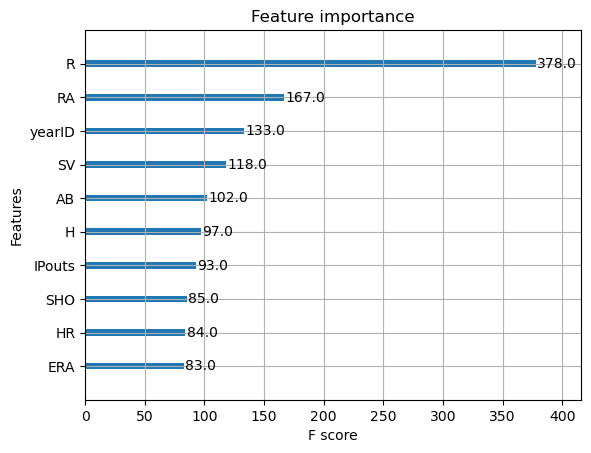

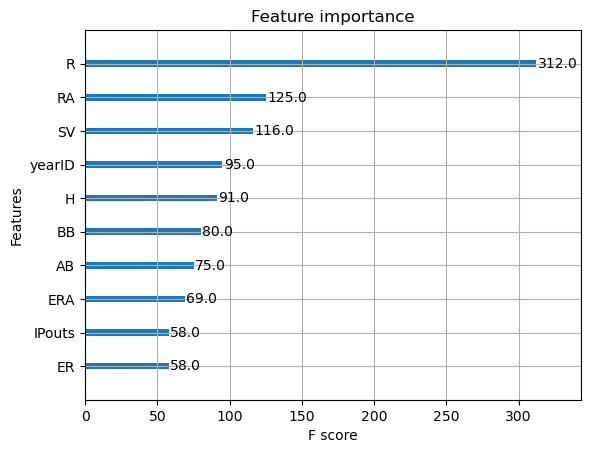

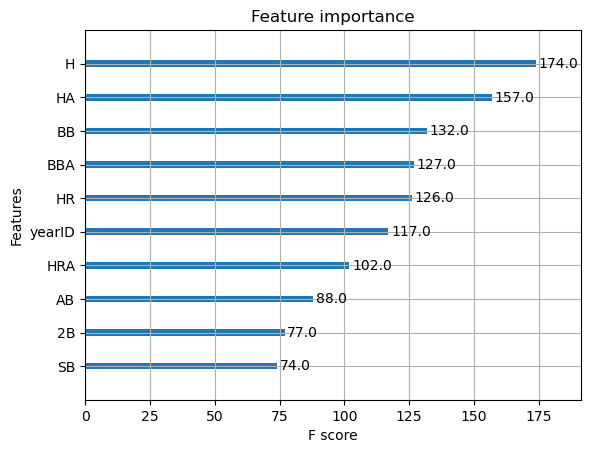

In [98]:
xgboost.plot_importance(xgb_model_1, max_num_features = 10)
xgboost.plot_importance(xgb_model_2, max_num_features = 10)
xgboost.plot_importance(xgb_model_3, max_num_features = 10)

In [99]:
xgb_pred_1 = xgb_model_1.predict(X_test_1)
xgb_pred_2 = xgb_model_2.predict(X_test_2)
xgb_pred_3 = xgb_model_3.predict(X_test_3)

In [100]:
print("RMSE:{}".format(round(math.sqrt(mean_squared_error(xgb_pred_1, y_test_1)),3)))
print("MAPE:{}".format(round(MAPE(xgb_pred_1, y_test_1), 3)))
print("R2:{}".format(round(r2_score(xgb_pred_1, y_test_1), 3)))
print("ACC(5%):{}".format(round(acc(y_test_1, xgb_pred_1), 3)))
print()

print("RMSE:{}".format(round(math.sqrt(mean_squared_error(xgb_pred_2, y_test_2)),3)))
print("MAPE:{}".format(round(MAPE(xgb_pred_2, y_test_2), 3)))
print("R2:{}".format(round(r2_score(xgb_pred_2, y_test_2), 3)))
print("ACC(5%):{}".format(round(acc(y_test_2, xgb_pred_2), 3)))
print()

print("RMSE:{}".format(round(math.sqrt(mean_squared_error(xgb_pred_3, y_test_3)),3)))
print("MAPE:{}".format(round(MAPE(xgb_pred_3, y_test_3), 3)))
print("R2:{}".format(round(r2_score(xgb_pred_3, y_test_3), 3)))
print("ACC(5%):{}".format(round(acc(y_test_3, xgb_pred_3), 3)))

RMSE:0.021
MAPE:3.415
R2:0.884
ACC(5%):0.767

RMSE:0.02
MAPE:3.009
R2:0.901
ACC(5%):0.8

RMSE:0.036
MAPE:5.372
R2:0.613
ACC(5%):0.7


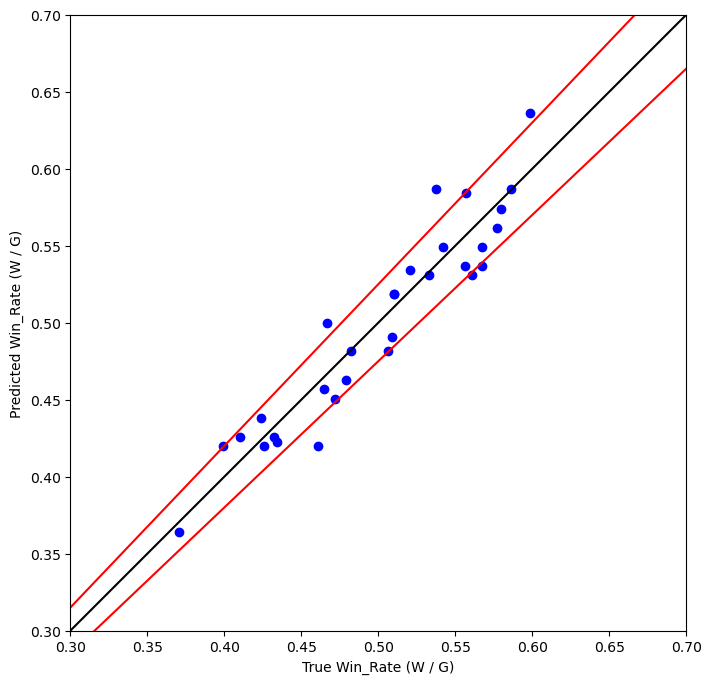

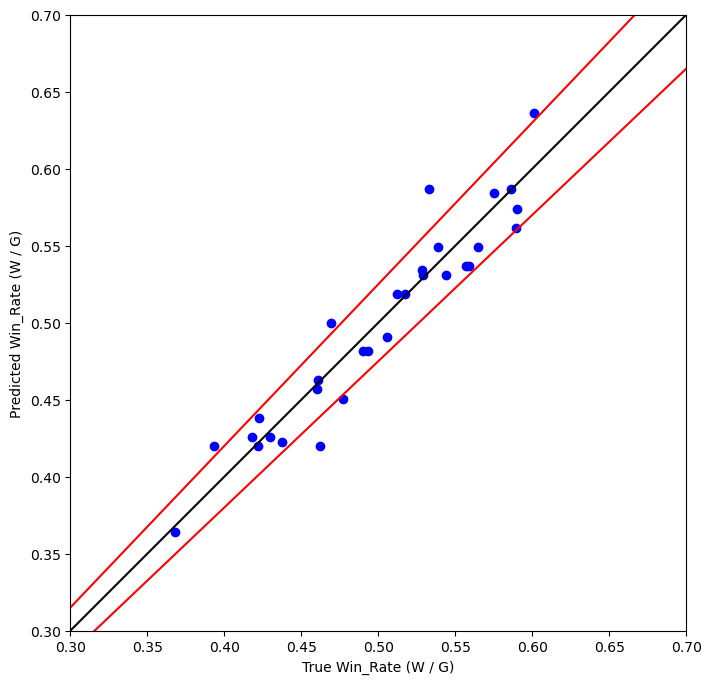

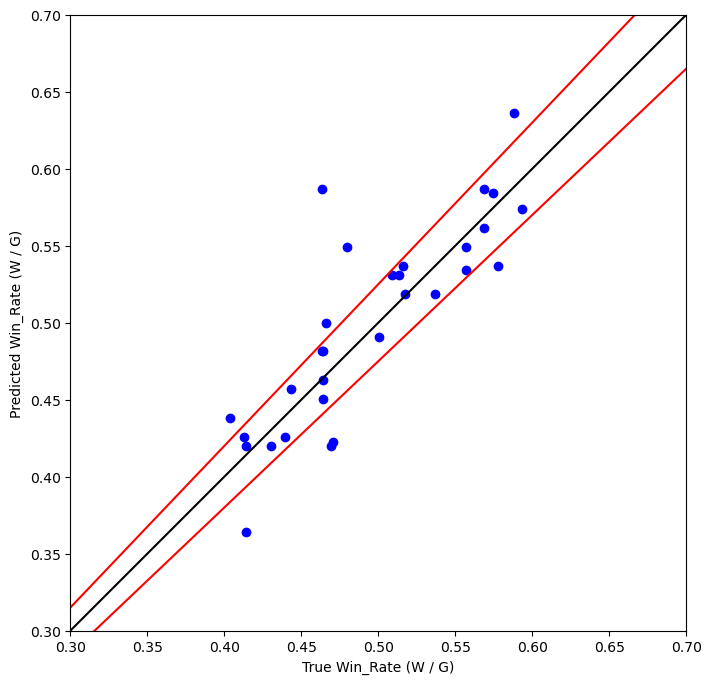

In [101]:
plotTestingDataPredictions_5(xgb_pred_1, y_test_1)
plotTestingDataPredictions_5(xgb_pred_2, y_test_2)
plotTestingDataPredictions_5(xgb_pred_3, y_test_3)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


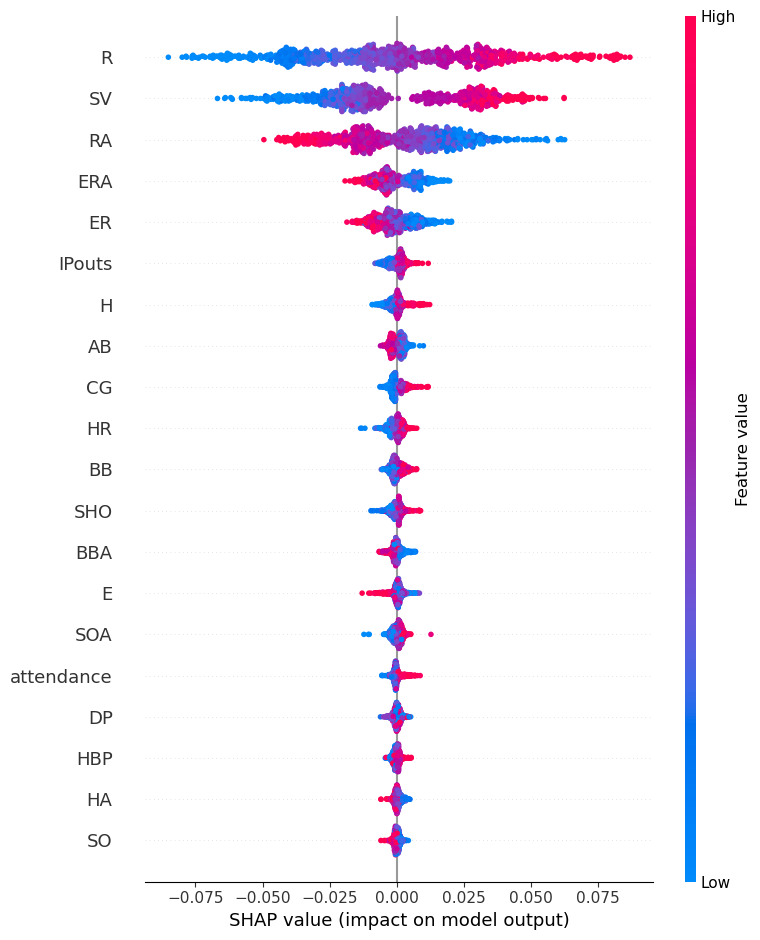

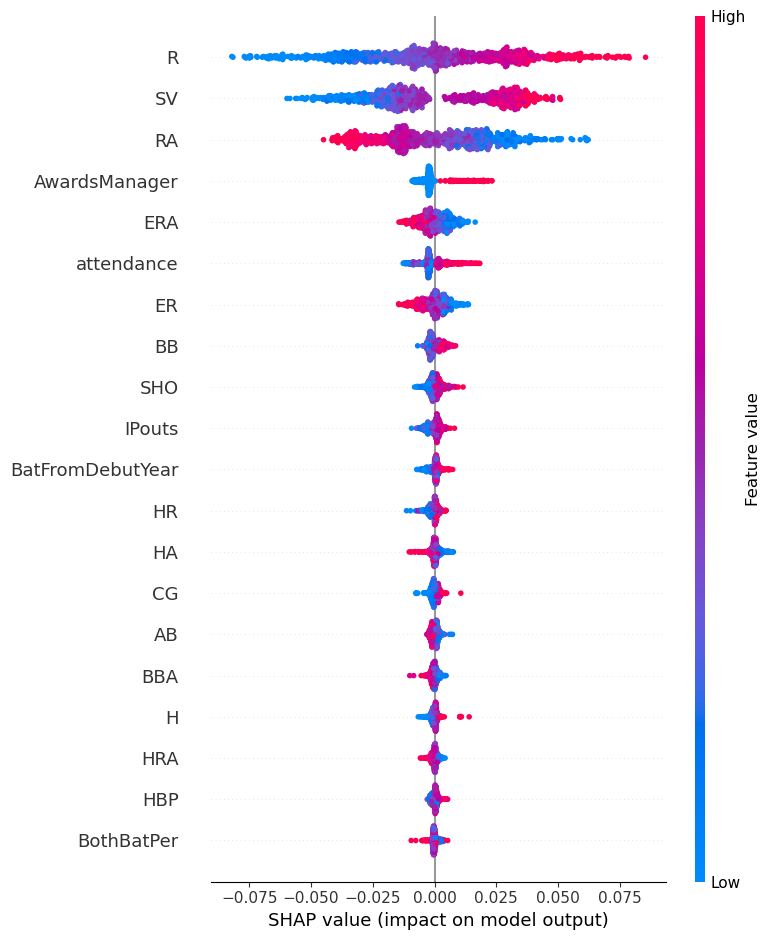

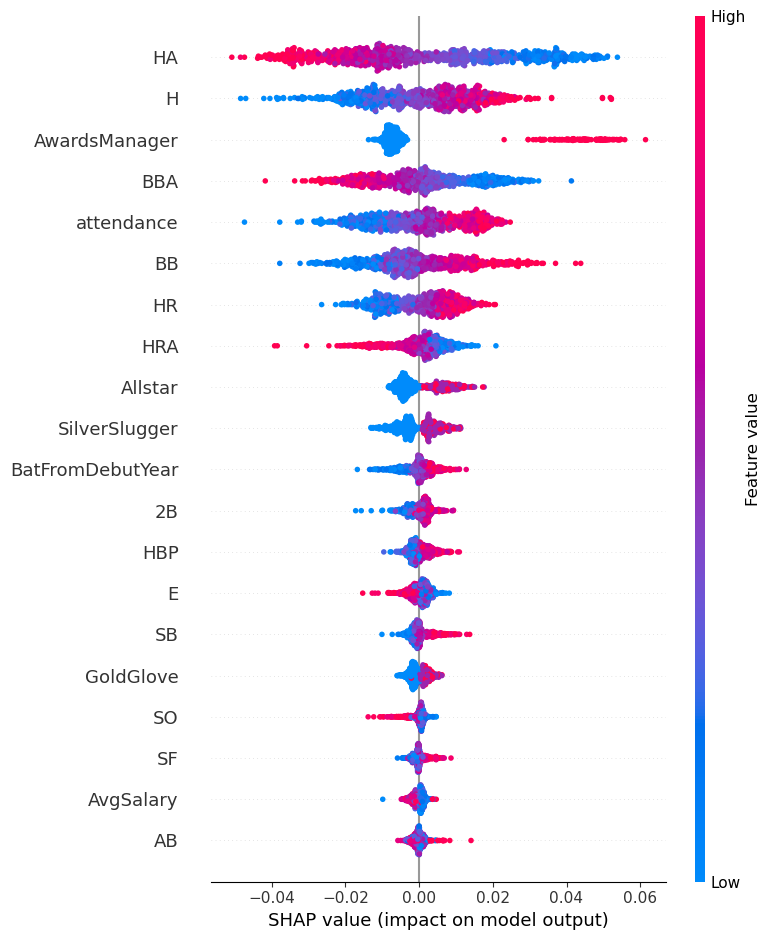

In [102]:
xgb_1 = XGBRegressor(n_estimators=300,seed=777)
xgb_1.fit(X_train_1, y_train_1)
explainer_1 = shap.TreeExplainer(xgb_1)
shap_values_1 = explainer_1.shap_values(X_train_1)
shap.summary_plot(shap_values_1, X_train_1)

xgb_2 = XGBRegressor(n_estimators=300,seed=777)
xgb_2.fit(X_train_2, y_train_2)
explainer_2 = shap.TreeExplainer(xgb_2)
shap_values_2 = explainer_2.shap_values(X_train_2)
shap.summary_plot(shap_values_2, X_train_2)

xgb_3 = XGBRegressor(n_estimators=300,seed=777)
xgb_3.fit(X_train_3, y_train_3)
explainer_3 = shap.TreeExplainer(xgb_3)
shap_values_3 = explainer_3.shap_values(X_train_3)
shap.summary_plot(shap_values_3, X_train_3)

In [103]:
shap.summary_plot(shap_values, X_train_3, plot_type='bar')

NameError: name 'shap_values' is not defined

### w_hat = rs^2 / ra^2 + rs^2

In [683]:
w_hat = X_test_1['R']** gamma / (X_test_1['RA']** gamma + X_test_1['R']** gamma)
w_hat

1313    0.423523
1314    0.417239
1315    0.518181
1316    0.605962
1317    0.481066
1318    0.664640
1319    0.420057
1320    0.563363
1321    0.491951
1322    0.518033
1323    0.514765
1324    0.475605
1325    0.493664
1326    0.558219
1327    0.481528
1328    0.459656
1329    0.405941
1330    0.485437
1331    0.538309
1332    0.430431
1333    0.380592
1334    0.482161
1335    0.447349
1336    0.537790
1337    0.556929
1338    0.541052
1339    0.472932
1340    0.504809
1341    0.559517
1342    0.599543
dtype: float64

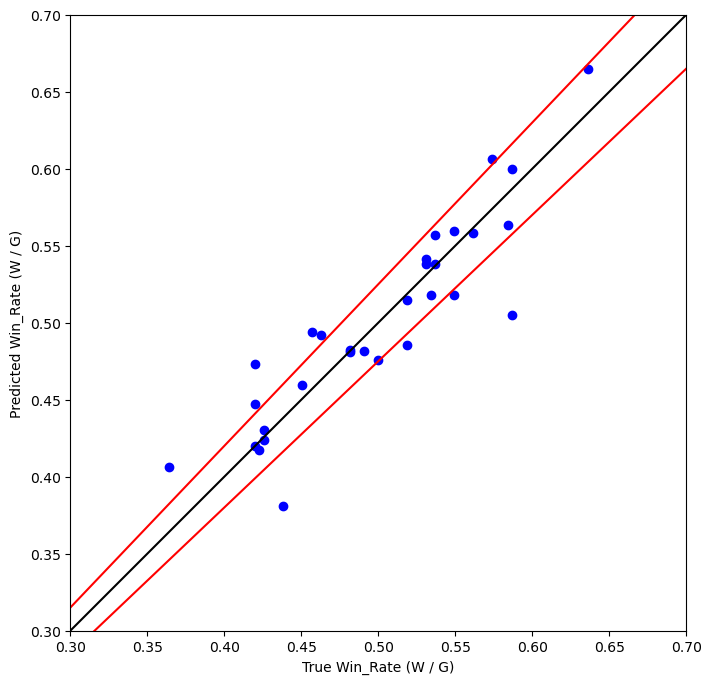

In [684]:
plotTestingDataPredictions_5(y_test_1, w_hat)

In [685]:
print("RMSE:{}".format(round(math.sqrt(mean_squared_error(w_hat, y_test_1)),3)))
print("MAPE:{}".format(round(MAPE(w_hat, y_test_1), 3)))
print("R2:{}".format(round(r2_score(w_hat, y_test_1), 3)))
print("ACC(5%):{}".format(round(acc(y_test_1, w_hat), 3)))

RMSE:0.028
MAPE:4.201
R2:0.805
ACC(5%):0.667


## Random Forest

In [686]:
rf_run_1 = RandomForestRegressor(max_depth=11, min_samples_leaf=8, min_samples_split=8,n_estimators = 500)
rf_run_1.fit(X_train_1, y_train_1)

rf_run_2 = RandomForestRegressor(max_depth=11, min_samples_leaf=8, min_samples_split=8,n_estimators = 500)
rf_run_2.fit(X_train_2, y_train_2)

rf_run_3 = RandomForestRegressor(max_depth=11, min_samples_leaf=8, min_samples_split=8,n_estimators = 500)
rf_run_3.fit(X_train_3, y_train_3)

RandomForestRegressor(max_depth=11, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=500)

In [687]:
# importances = rf_run.feature_importances_
# std = np.std([tree.feature_importances_ for tree in rf_run.estimators_], axis=0)
# indices = np.argsort(importances)[::-1][0:10]

# for f in range(10):
#     print("{}. feature {} ({:.3f})".format(f + 1, X_test.columns[indices][f], importances[indices[f]]))
    
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(10), importances[indices],
#        color = "b", yerr=std[indices], align="center")
# plt.xticks(range(10), X_test.columns[indices], rotation = 45)
# plt.xlim([-1, 10])
# plt.show()

In [688]:
rf_pred_1 = rf_run_1.predict(X_test_1)
rf_pred_2 = rf_run_2.predict(X_test_2)
rf_pred_3 = rf_run_3.predict(X_test_3)

In [689]:
print("RMSE:{}".format(round(math.sqrt(mean_squared_error(rf_pred_1, y_test_1)),3)))
print("MAPE:{}".format(round(MAPE(rf_pred_1, y_test_1), 3)))
print("R2:{}".format(round(r2_score(rf_pred_1, y_test_1), 3)))
print("ACC(5%):{}".format(round(acc(y_test_1, rf_pred_1), 3)))
print()

print("RMSE:{}".format(round(math.sqrt(mean_squared_error(rf_pred_2, y_test_2)),3)))
print("MAPE:{}".format(round(MAPE(rf_pred_2, y_test_2), 3)))
print("R2:{}".format(round(r2_score(rf_pred_2, y_test_2), 3)))
print("ACC(5%):{}".format(round(acc(y_test_2, rf_pred_2), 3)))
print()

print("RMSE:{}".format(round(math.sqrt(mean_squared_error(rf_pred_3, y_test_3)),3)))
print("MAPE:{}".format(round(MAPE(rf_pred_3, y_test_3), 3)))
print("R2:{}".format(round(r2_score(rf_pred_3, y_test_3), 3)))
print("ACC(5%):{}".format(round(acc(y_test_3, rf_pred_3), 3)))
print()

RMSE:0.024
MAPE:3.72
R2:0.832
ACC(5%):0.8

RMSE:0.024
MAPE:3.804
R2:0.833
ACC(5%):0.767

RMSE:0.036
MAPE:5.312
R2:0.473
ACC(5%):0.667



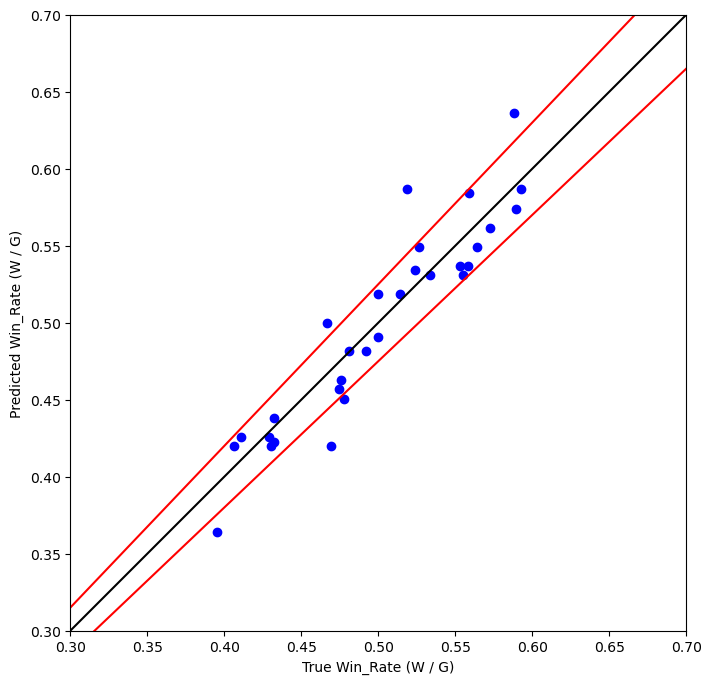

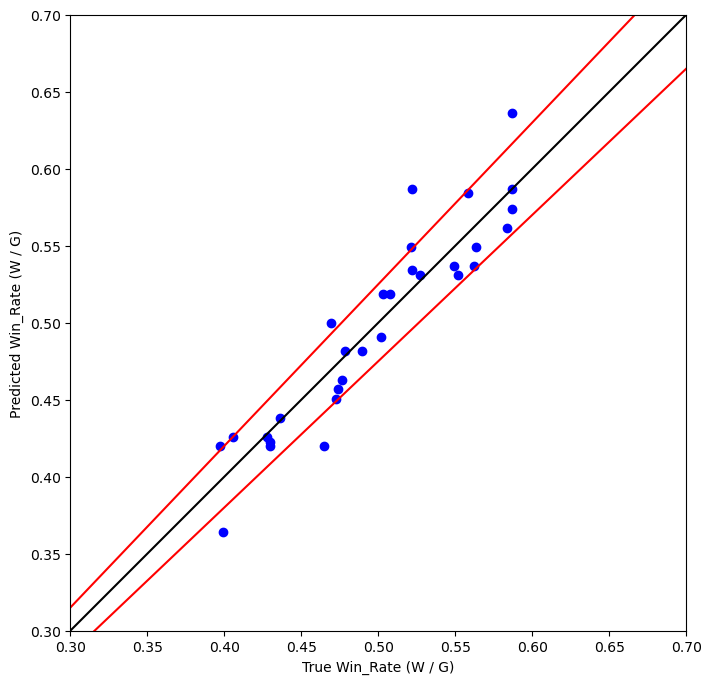

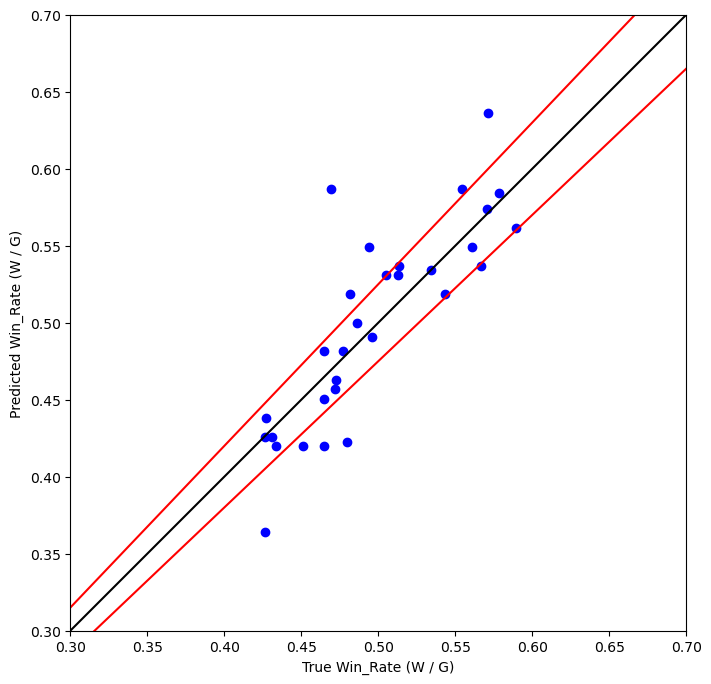

In [690]:
plotTestingDataPredictions_5(rf_pred_1, y_test_1)
plotTestingDataPredictions_5(rf_pred_2, y_test_2)
plotTestingDataPredictions_5(rf_pred_3, y_test_3)

array([[1.        , 0.18700318],
       [0.18700318, 1.        ]])

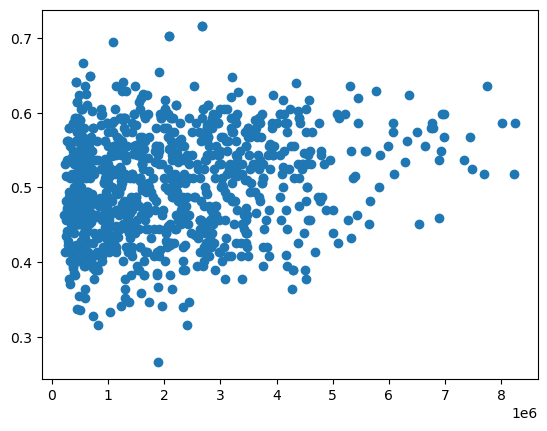

In [115]:
plt.scatter(model['AvgSalary'], model['Win_rate'])
np.corrcoef(model['AvgSalary'], model['Win_rate'])

In [119]:
model[(model['yearID'] == 2001) & (model['OAK'] == 1)].Win_rate

861    0.62963
Name: Win_rate, dtype: float64

# Deep Learning

In [691]:
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [692]:
X = scaler.fit_transform(model_x_data)

NameError: name 'scaler' is not defined

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

In [ ]:
x_data = torch.Tensor(X).float()
y_data = torch.Tensor(y)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        x = torch.sigmoid(self.linear2(x))
        return x
    
    def predict(self, x):
        pred = self.forward(x)
        if pred >= 0.5:
            return 1
        else:
            return 0


In [ ]:
torch.manual_seed(2)
model = Model(32, 32, 1)

print(list(model.parameters()))

In [ ]:
lossFunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
losses = []
for i in range(epochs):
    yPred = model.forward(x_data)
    loss = lossFunc(yPred, y_data)
    if i % 100 == 0:
        print("epoch : ", i, "loss", loss.item())
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), losses)
plt.ylabel("loss")
plt.xlabel("epoch")

# DL2

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [ ]:
X, y = model_x_data, model_y_data
# X = torch.tensor(model_x_data.values)
# y = torch.tensor(model_y_data.values)
X = df_to_tensor(model_x_data)
y = df_to_tensor(model_y_data)

In [ ]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(y).unsqueeze(-1)

In [ ]:
X = (X - torch.mean(X)) / torch.std(X)

In [ ]:
model = nn.Linear(32, 1)

In [ ]:
criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
for epoch in range(1, 101):
    optimizer.zero_grad()
    
    y_predicted = model(X)
    
    loss = criterion(y_predicted, y)
    
    loss.backward()
    
    optimizer.step()
    
    if epoch % 10 == 0:
        print('{}epoch, loss: {:.4f}'.format(epoch, loss.item()))

In [ ]:
y_predicted = y_predicted.detach().numpy()

In [ ]:
y_predicted = np.ravel(y_predicted, order='C')

In [ ]:
print("RMSE:{}".format(round(math.sqrt(mean_squared_error(y_predicted, model_y_data)),3)))
print("MAPE:{}".format(round(MAPE(y_predicted, model_y_data), 3)))
print("R2:{}".format(round(r2_score(y_predicted, model_y_data), 3)))
print("ACC(10%):{}".format(round(acc(model_y_data, y_predicted), 3)))

In [ ]:
plotTestingDataPredictions_10(y_predicted, model_y_data)